<a href="https://colab.research.google.com/github/SalomonMalka/Black-and-white-image-colorization/blob/Salomon/Image_Colorization_with_U_Net_and_GAN_V0_cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Colorization with U-Net and GAN Tutorial - Version 0.1

# 1 - Imports and data loading

In [1]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None

### 1.1 - Imports in colab

The following code install fastai, a library needed essentially in this project to use the COCO database.

In [2]:
!pip install fastai==2.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.9/187.9 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.4/831.4 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 72.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 79.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.3/23.3 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.3/23.3 MB 18.0 MB/s eta 0:00:00
     ━━━━━━

The following will download about 20,000 images from COCO dataset.

In [3]:
 from fastai.data.external import untar_data, URLs
 coco_path = untar_data(URLs.COCO_SAMPLE)
 coco_path = str(coco_path) + "/train_sample"
 use_colab = True

In [5]:
if use_colab == True:
    path = coco_path
else:
    path = "Your path to the dataset"
    
paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names
np.random.seed(123)
paths_subset = np.random.choice(paths, 10_000, replace=False) # choosing 10_000 images randomly
rand_idxs = np.random.permutation(10_000)
train_idxs = rand_idxs[:8000] # choosing the first 8000 as training set
val_idxs = rand_idxs[8000:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(f"Size of train and validation set: {len(train_paths)}, {len(val_paths)}")

Size of train and validation set: 8000, 2000


Print some images from the train dataset

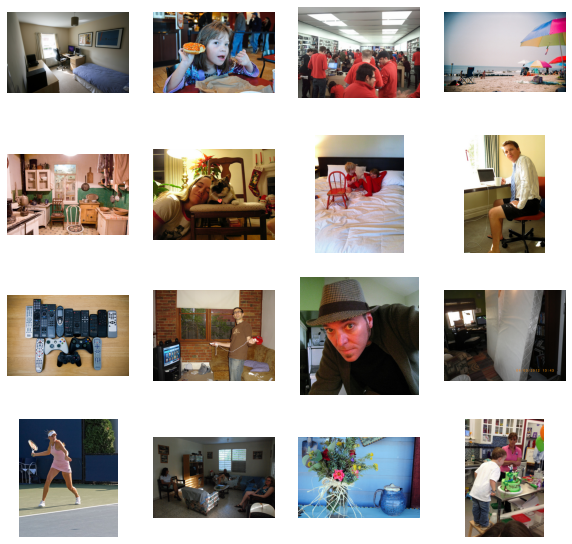

In [6]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

### 1.2 - Making Datasets and DataLoaders

We separate the data into **L\*a\*b** channels. The **L** channel will be the **black-and-white** images and the **a*b** channels we aim to **predict**.

In [7]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        
        self.split = split
        self.size = SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        
        return {'L': L, 'ab': ab}
    
    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

Create train and validation dataloader

In [8]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

# print the dimention of the data
data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print("L channel image shape :", Ls.shape)
print("a*b channel image shape :", abs_.shape)
print(f"Lenght of train and validation set batches: {len(train_dl)}, {len(val_dl)}")

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  self.size = _setup_size(size, error_msg="Please provide only two dimensions (h, w) for size.")
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  assert self._num_workers == 0


L channel image shape : torch.Size([16, 1, 256, 256])
a*b channel image shape : torch.Size([16, 2, 256, 256])
Lenght of train and validation set batches: 500, 125


Plot the L, a and b channel of an image from the data. 

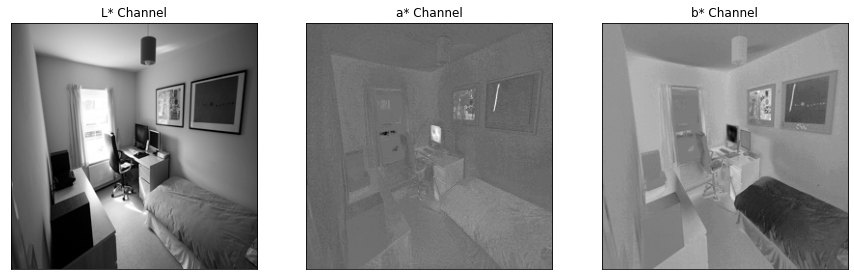

In [9]:
data = next(iter(train_dl))
data['L'].shape
data['ab'].shape

L_channel = data['L'][0][0]
a_channel = data['ab'][0][0]
b_channel = data['ab'][0][1]

fig, axes = plt.subplots(1,3 , figsize = (15,15))
axes[0].imshow(L_channel, cmap = 'gray')
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title("L* Channel")

axes[1].imshow(a_channel, cmap = 'gray')
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title("a* Channel")

axes[2].imshow(b_channel, cmap = 'gray')
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title("b* Channel")
plt.show()

# 2 - Create the model

### 2.0 - Utility functions

In [10]:
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    
def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")

def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")
        
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

### 2.1 - Main Model 

We use fastai and torchvision model to create a Unet composed with resnet18 architechture as the encoder part.  

In [11]:
#!pip install fastai==2.4
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

In [12]:
def ResUnet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18, pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

### 2.2 Pretraining the generator for colorization task

In [16]:
def train_model(model, train_dl, opt, criterion, epochs):
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = model(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()
            loss_meter.update(loss.item(), L.size(0))
            
        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

unet = ResUnet(n_input=1, n_output=2, size=256)
opt = optim.Adam(unet.parameters(), lr=1e-4)
criterion = nn.L1Loss()
num_epochs = 2     
train_model(unet, train_dl, opt, criterion, num_epochs)
torch.save(unet.state_dict(), "res18-unet.pt")

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  assert self._num_workers == 0
<ipython-input-16-5f0faf0e97bb>:11: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:350.)
  loss_meter.update(loss.item(), L.size(0))


Epoch 1/2
L1 Loss: 0.08601


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2/2
L1 Loss: 0.08314
